# Phytoplankton biomass

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr

from dask.distributed import Client

import catalog
import util

xr.set_options(keep_attrs=True)

/glade/work/kristenk/miniconda/envs/cesm-exp/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools

In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT

### Parameters

In [5]:
casename = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1'
component = 'pop'
stream = 'h'

cluster_scheduler_address = None

In [6]:
assert component in ['pop']
assert stream in ['h', 'h.ecosys.nday1']

### Connect to cluster

In [7]:
if cluster_scheduler_address is None:
    cluster, client = util.get_ClusterClient()
    cluster.scale(12)
else:
    client = Client(cluster_scheduler_address)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.59:42586,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load the data

In [31]:
dsets = catalog.to_dataset_dict(
    case=casename,
    component=component,
    stream=stream,
)
dsets.keys()

dict_keys(['g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1.pop.h'])

## Compute long-term mean and plot

In [32]:
ds = dsets[f'{casename}.{component}.{stream}']

### Variable list

In [33]:
variables =['diatC', 'coccoC','spC','diazC']

In [34]:
keep_vars=['z_t','z_t_150m','dz','time_bound','TAREA','TLAT','TLONG'] + variables
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

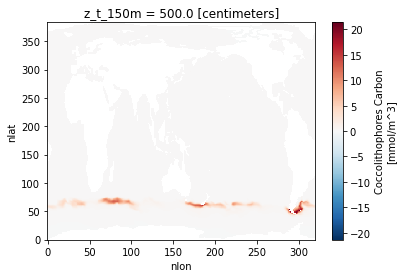

In [35]:
ds.coccoC.isel(time=0,z_t_150m=0).plot()

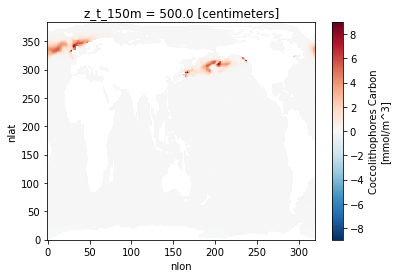

In [36]:
ds.coccoC.isel(time=6,z_t_150m=0).plot()

In [37]:
ds

<xarray.Dataset>
Dimensions:            (time: 120, d2: 2, z_t: 60, z_t_150m: 15, nlat: 384, nlon: 320)
Coordinates:
  * z_t                (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m           (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
    TLONG              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: time, d2, nlat, nlon
Data variables:
    time_bound         (time, d2) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    dz                 (time, z_t) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    photoC_sp_zint     (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    photoC_diat_zint   (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    photoC_diaz_zint   (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    photoC_cocco_zint  (time, nlat, nlon) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    spC                (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
    diatC              (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
    diazC              (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
    coccoC             (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
Attributes:
    title:             g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2022-05-01 at 16:57:11.2
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [38]:
dt_wgt = ds.time_bound.diff('d2').squeeze()
dt_wgt /= dt_wgt.sum()
dt_wgt

<xarray.DataArray 'time_bound' (time: 120)>
dask.array<truediv, shape=(120,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Dimensions without coordinates: time
Attributes:
    long_name:  boundaries for time-averaging interval
    units:      days since 0000-01-01 00:00:00

In [39]:
ds = ds.weighted(dt_wgt).mean('time')

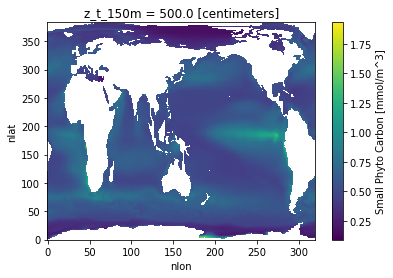

In [40]:
ds['spC'].isel(z_t_150m=0).plot()

### Phytoplankton biomass at the surface

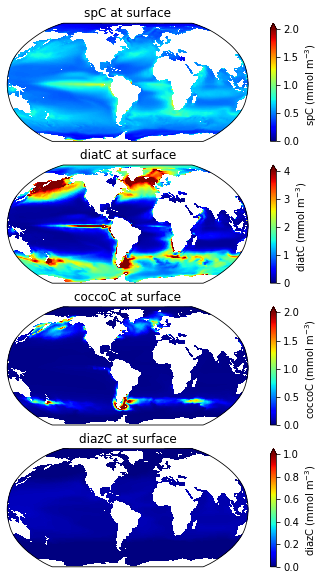

In [41]:
###### 
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at surface', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.spC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')


ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at surface', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.diatC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')


ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at surface', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.coccoC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at surface', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.diazC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

### Phytoplankton biomass at 100m

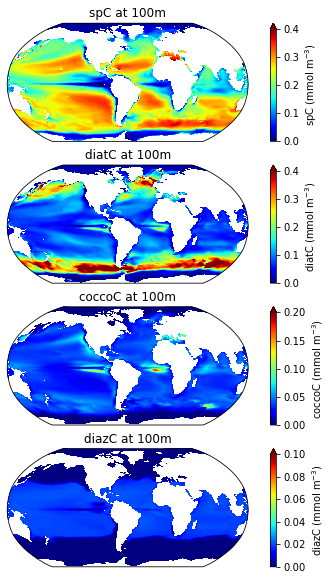

In [42]:
###### 
fig = plt.figure(figsize=(8,10))


ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at 100m', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.spC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at 100m', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.diatC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at 100m', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.coccoC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at 100m', fontsize=12)
lon, lat, field = util.adjust_pop_grid(lons, lats,  ds.diazC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')